# Outline of this advanced lane detection

* Calibrate the Camera and figure our distortion coeffcients (Camera Calibration is done in a seperate notebook)
* Undistort the image using calibration matrix
* Threshold using X gradient and S channel from HLS color space
* Perspective Transform for bird's eye view
* Figure out the lane lines
* figure out the curvature
* output


Importing the libraries needed for this project

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from glob import glob # for reading in multiple files

from moviepy.editor import VideoFileClip
from IPython.display import HTML #, display, Image
import pickle

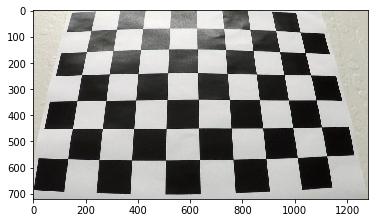

In [18]:
# an example of one of the many chessboard images for camera calibration 
# Please see "Calibrate Camera with OpenCV" for camera calibration code
calibration_img = mpimg.imread('camera_cal/calibration3.jpg')
plt.imshow(calibration_img)

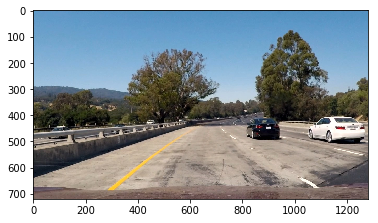

In [47]:
test_folder = "test_images"
output_folder = "output_images"

image = mpimg.imread(test_folder+'/test1.jpg')
#image = mpimg.imread(test_folder+'/test2.jpg')
#image = mpimg.imread(test_folder+'/test3.jpg')
#image = mpimg.imread(test_folder+'/test4.jpg') # difficult
#image = mpimg.imread(test_folder+'/test5.jpg')
#image = mpimg.imread(test_folder+'/test6.jpg')

#image = mpimg.imread(test_folder+'/straight_lines2.jpg')
plt.imshow(image)

## Undistort the image using calibration matrix

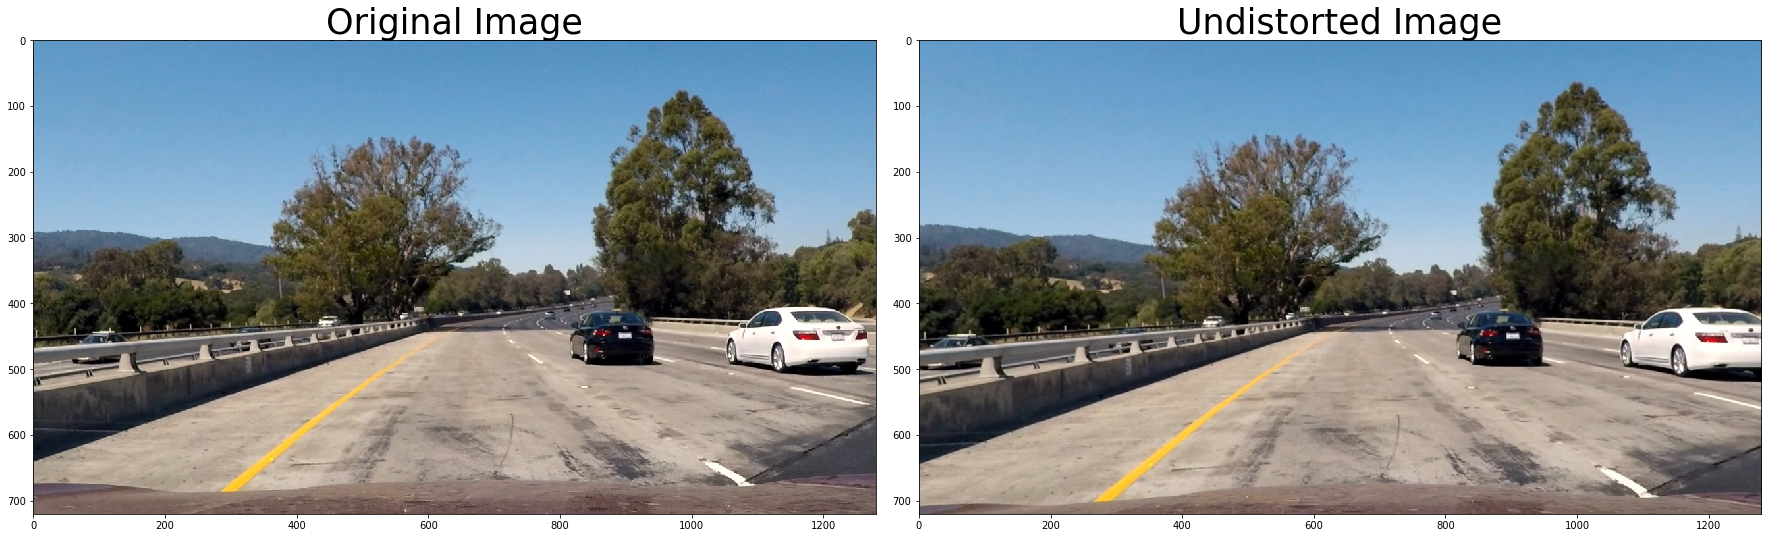

In [48]:
# Read in the saved camera matrix and distortion coefficients saves as a pickle file
# These are the arrays calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def undistort_image (img, mtx, dist):
    # 1) Undistort using mtx and dist
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

undist_img = undistort_image (image, mtx, dist)

# Code from 6.12 "Correction for Distortion Quiz"
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=35)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [21]:
#Saving undistorted test images in a folder
for filename in glob(test_folder + '/*'):
    starting_position = filename.find("/")
    imagename = filename[starting_position+1:]
    image_input = mpimg.imread(filename)
    undistorted_image = undistort_image (image_input, mtx, dist)
    mpimg.imsave(output_folder + '/undistorted_images/' + imagename, undistorted_image)
    

## Threshold using X gradient and S channel from HLS color space

(720, 1280)
(720, 1280)


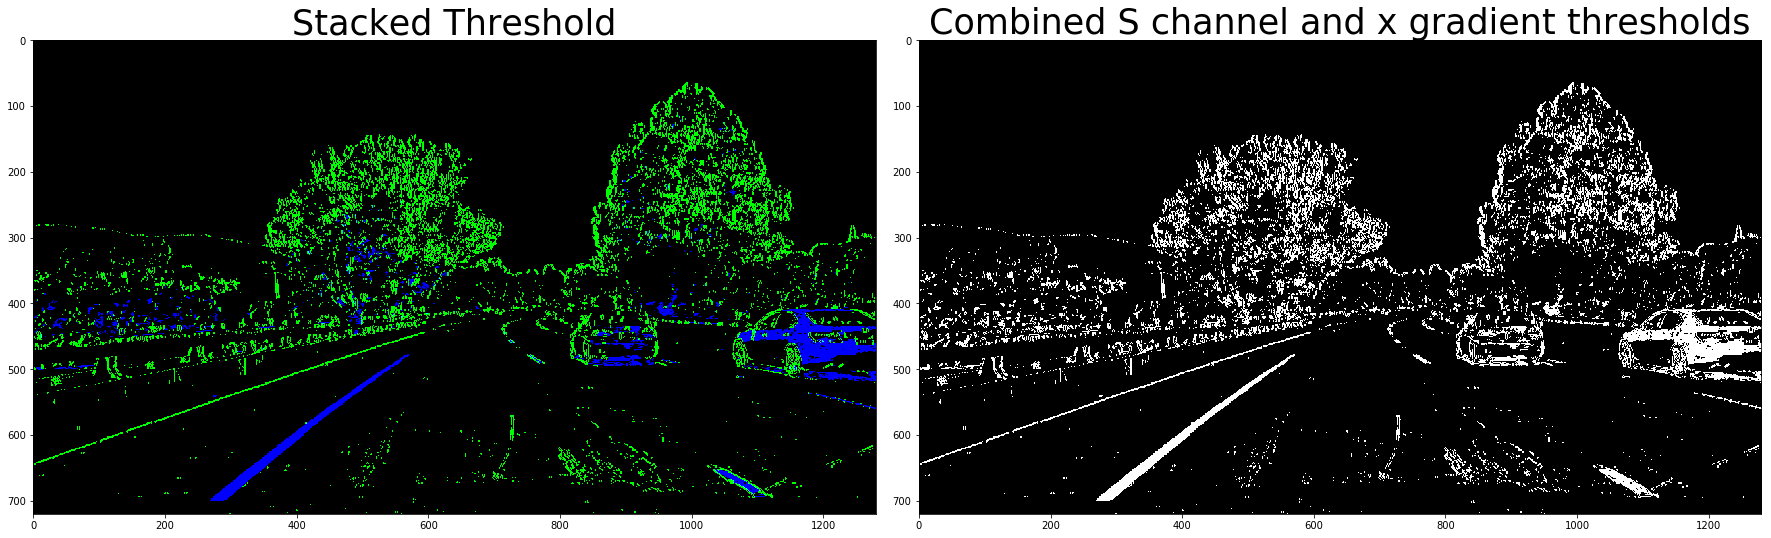

In [61]:
#Code from Quiz 7.12

def threshold_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary
    
color_bin, combined_bin = threshold_image(undist_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_bin)
ax1.set_title('Stacked Threshold', fontsize=35)
ax2.imshow(combined_bin,  cmap='gray')
ax2.set_title('Combined S channel and x gradient thresholds', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [63]:
#Saving thresholded test images in a folder
for filename in glob('output_images/undistorted_images/*'):
    starting_position = filename.rfind("/") #rfind for finding the rightmost '/'
    imagename = filename[starting_position+1:]
    image_input = mpimg.imread(filename)
    _ , thresholded_image = threshold_image (image_input)
    print(thresholded_image.shape)
    mpimg.imsave(output_folder + '/threshold_images/' + imagename, thresholded_image, cmap ='gray')

(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


## Perspective Transform for bird's eye view

(720, 1280)
(720, 1280)


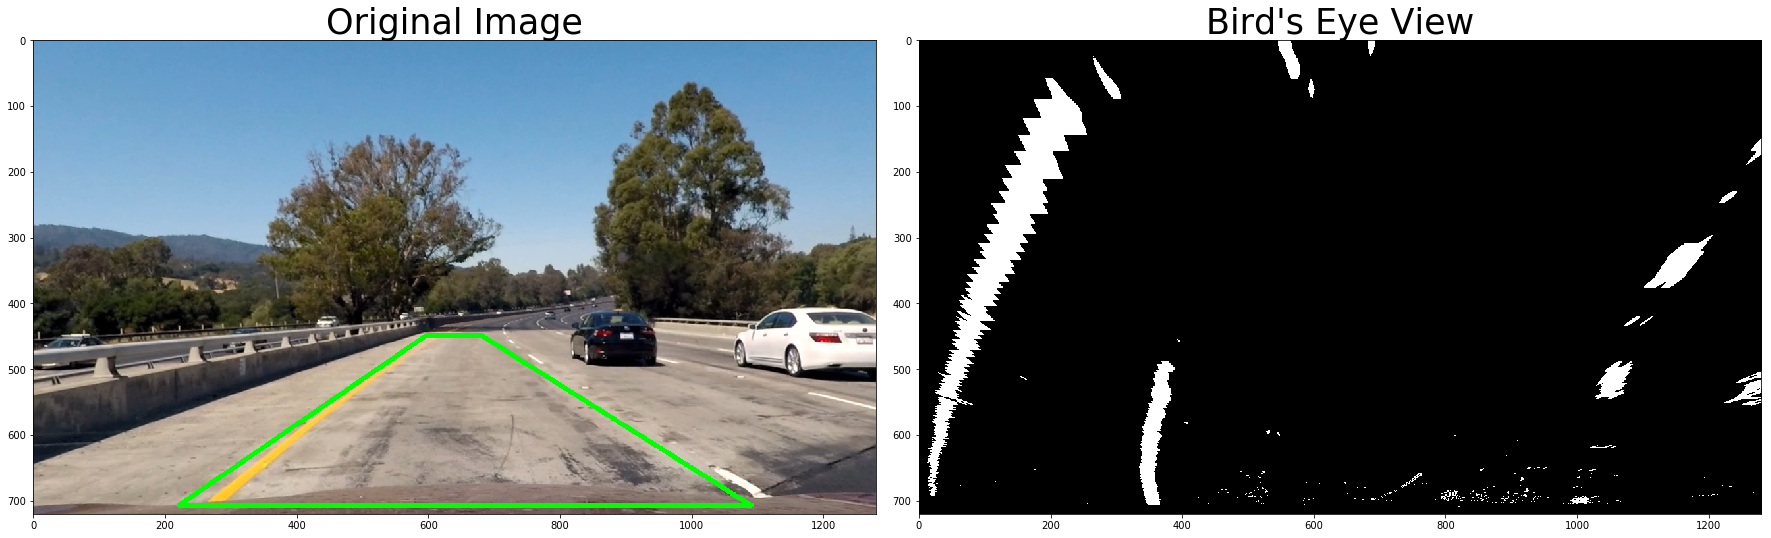

In [60]:
# We are assuming road is a flat place - which is strictly not ture
# pick four points in a trapezoidal shape (similar to region masking)
# The source and destination points for applying perspective transformation
# This is a very important and tricky step as you will have to play with the source points to have the transform which will show parallel lines

# *********************************************************
# Global Variables needed when running the final pipeline
# *********************************************************

src = np.float32([[220,707], [597,448], [680,448], [1091,707]])
dst= np.float32([[320,707], [320,200], [970,200], [970,707]]) 



# Perspective transform for bird's eye view

def perspective_transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags =  cv2.INTER_LINEAR)
    return warped, M, Minv

binary_warped, M, Minv = perspective_transform(combined_bin, src, dst)

vertices = np.array(src, np.int32)
vertices = vertices.reshape((-1, 1, 2))
o_image = undist_img.copy()
bird = cv2.polylines(o_image, [vertices], True, (0, 255, 0), 5)

# Plot image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bird)
ax1.set_title('Original Image', fontsize=35)
ax2.imshow(binary_warped, cmap = 'gray')
ax2.set_title("Bird's Eye View", fontsize=35)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [64]:
#Saving bird's eye view images in a folder
for filename in glob('output_images/threshold_images/*'):
    starting_position = filename.rfind("/") #rfind for finding the rightmost '/'
    imagename = filename[starting_position+1:]
    image_input = mpimg.imread(filename)
    birdeyeview_image, _, _ = perspective_transform (image_input, src, dst)
    print(birdeyeview_image.shape)
    mpimg.imsave(output_folder + '/birds_eye_view_images/' + imagename, birdeyeview_image, cmap = 'gray')

(720, 1280, 4)
(720, 1280, 4)
(720, 1280, 4)
(720, 1280, 4)
(720, 1280, 4)
(720, 1280, 4)
(720, 1280, 4)
(720, 1280, 4)


## Find first lane line

(720, 1280, 3)
(720, 1280)
[ -5.51845963e-04   5.41762048e-01   2.31900573e+02]
[  4.66425053e-04  -9.58190293e-01   1.42412216e+03]


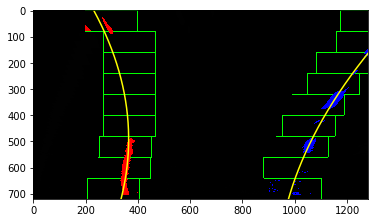

In [57]:
# binary_warped from previous step
# Code from Quiz 8.4

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    
    # IMPORTANT: Using lower half of the image to figure out lane starting. 
    # Using x starting position at __50__ because sometimes the 
    # divider can be thought of as lane lines and depending on the divider shadow 
    # it can be considered a lane when using histogram plots
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,50:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    print(out_img.shape)
    print(binary_warped.shape)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # print(leftx_current)
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows 
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        #Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #image = cv2.rectangle(image, start_point, end_point, color, thickness)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("an error occured!")
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial_first_lane(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    # linspace: Return evenly spaced numbers over a specified interval.
    #           Returns num evenly spaced samples, calculated over the interval [start, stop]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # ***********************************************************************
    # In the final pipeline comment this code so we aren't plotting fit lines
    # ***********************************************************************

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img


left_fit, right_fit, out_img = fit_polynomial_first_lane(binary_warped)

print(left_fit)
print (right_fit)
plt.imshow(out_img)

In [58]:
#Saving first lane lines in a folder
for filename in glob('output_images/birds_eye_view_images/*'):
    starting_position = filename.rfind("/") #rfind for finding the rightmost '/'
    imagename = filename[starting_position+1:]
    image_input = mpimg.imread(filename)
    # cv2.rectangle will require full path??
    print(filename)
    #image_fullpath = 'output_images/birds_eye_view_images/'+ image_input
    _, _, draw_lines = fit_polynomial_first_lane(image_input)
    mpimg.imsave(output_folder + '/draw_lane_lines/' + imagename, draw_lines)

output_images/birds_eye_view_images/test1.jpg
(720, 1280, 12)
(720, 1280, 4)


error: /tmp/build/80754af9/opencv_1512491964794/work/modules/core/src/matrix.cpp:1168: error: (-215) cn <= 4 in function scalarToRawData


## Lane line search using a lane line from the previous frame

[  7.43772396e-04  -1.28555573e+00   8.80346245e+02]
[  7.13914314e-04  -1.22476093e+00   1.49942198e+03]


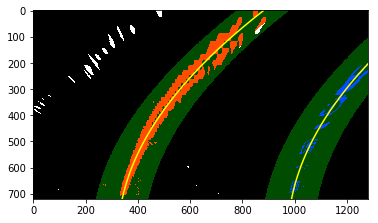

In [8]:
#code from Quiz 8.5

# Load our image - this should be a new frame since last time!

#*****************************************************************
# We are assuming we are using binary_warped
#*****************************************************************

# This finction uses polynomial fit values from the previous frame

def fit_poly(img_shape, leftx, lefty, rightx, righty): # to fit the next lane line
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calculate both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(left_fit, right_fit, binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # ***********************************************************************
    # In the final pipeline comment this code so we aren't plotting fit lines
    # ***********************************************************************
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fit, right_fit, result

left_fit, right_fit, result = search_around_poly(left_fit, right_fit, binary_warped)

# View your output
print(left_fit)
print (right_fit)
plt.imshow(result)


## Measure Real Curvature

In [24]:
#Code from Quiz 8.7

def measure_curvature_real(binary_warped, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 60/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    leftx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    rightx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Calculation of R_curve (radius of curvature) #####
    # Calculation of the left line here
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    # Calculation of the right line here
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    ##### Calculating the position of the car #####
    # assuming camera is mounted at the center of the car
    car_x = binary_warped.shape[1]/2
    l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (l+r) /2
    # Changing to x in world space
    dist_from_center = (car_x - lane_center) * xm_per_pix
    
    return left_curverad, right_curverad, dist_from_center

left_curverad, right_curverad, dist_from_center = measure_curvature_real(binary_warped, left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm', 'distance from center =',dist_from_center, 'm')



847.023721811 m 920.366148624 m distance from center = -0.132549183195 m


Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:



## Draw on original Image

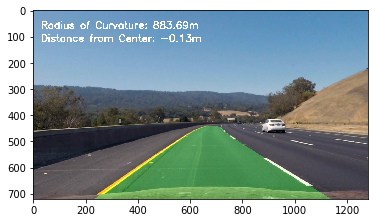

In [25]:
def draw_on_original_image(binary_warped, image, left_fit, right_fit, Minv, left_curverad, right_curverad, dist_from_center):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature = (abs(left_curverad) + abs(right_curverad))/2
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(curvature) + 'm'
    cv2.putText(result,text,(30,70), font, 1.25,(255,255,255),3)
    text = 'Distance from Center: ' + '{:04.2f}'.format(dist_from_center) + 'm'
    cv2.putText(result,text,(30,120), font, 1.25,(255,255,255),3)
    
    return result

result= draw_on_original_image(binary_warped, undist_img, left_fit, right_fit, Minv, left_curverad, right_curverad, dist_from_center)
plt.imshow(result)


In [26]:
# Line class to store all the relevant data about a particular lane line

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Counter for number
        self.linenum=0
    
    # Function to take the current fit of the lane and return weighted/average fit from the previous 'n' fits
    # Using last 15 fits
    def add_fit(self, fit):
        if self.linenum > 15:
            if fit is not None:
                self.detected= True
                self.current_fit.append(fit)
                if len(self.current_fit) > 15:
                    self.current_fit= self.current_fit[len(self.current_fit)-15:]
                self.best_fit = np.average (self.current_fit, axis=0)

            else:
                self.detected = False
                if len(self.current_fit) > 0:
                    self.best_fit= np.average(self.current_fit, axis=0)
        else:
            if fit is not None:
                self.detected= True
                self.current_fit.append(fit)
                if len(self.current_fit) > 1:
                    self.current_fit= self.current_fit[len(self.current_fit)-1:]
                self.best_fit = np.average (self.current_fit, axis=0)

            else:
                self.detected = False
                if len(self.current_fit) > 0:
                    self.best_fit= np.average(self.current_fit, axis=0)

## Process Video Frame by Frame - Main Pipeline

In [64]:
def process_image(img):
    
    image1= np.copy(img)
    
    #image, binary_warped, Minv= imagepro(image1)
    
    # mtx and dist are available from calculations before but re-reading again 
    # to be used in undistort_image function
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    undist_img = undistort_image(image1, mtx, dist)
    color_bin, combined_bin = threshold_image(undist_img)
    binary_warped, M, Minv = perspective_transform(combined_bin, src, dst)
    
    if not left_line.detected or not right_line.detected:
        # Find the lanes using histogram method
        left_fit, right_fit, _ = fit_polynomial_first_lane(binary_warped)
    else:
        # Search in the area of previous found lanes
        left_fit, right_fit, _ = search_around_poly(left_line.best_fit, right_line.best_fit, binary_warped)
        
    # Checking for curvature and distance
    
    if left_fit is not None and right_fit is not None:
        
        left_curverad, right_curverad, dist_from_center = measure_curvature_real(binary_warped, left_fit, right_fit)
        
        if abs(left_curverad) < 100 or abs(right_curverad)<100:
            left_fit = None
            right_fit= None
        
        # Checking curvatuyre ratios since the lanes should always be almost parallel - still giving some leeway to be different in curvatures
        if abs(left_curverad)/abs(right_curverad) < 0.3 or abs(left_curverad)/abs(right_curverad)> 3:
            left_fit = None
            right_fit= None
            
        
            
    if left_fit is not None and right_fit is not None:
        y_eval = image.shape[0]
        #print("line number", left_line.linenum)
        #print (left_fit)
        #print (right_fit)
            
        l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        lane_size= abs(l-r)
        #print("left lane", l, "right lane", r)
        #print(lane_size)
        #print ("left curvature:", left_curverad, "   right curvature:", right_curverad )
        
        
        # Checking for the lane line width
        if lane_size < 400 or lane_size > 1000:
            left_fit = None
            right_fit = None
            
    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)
        
    if left_line.best_fit is not None and right_line.best_fit is not None:
        left_curverad, right_curverad, dist_from_center = measure_curvature_real(binary_warped, left_line.best_fit, right_line.best_fit)
        img_out = draw_on_original_image(binary_warped, undist_img, left_line.best_fit, 
                                         right_line.best_fit, Minv, left_curverad, right_curverad, dist_from_center)
    else:
        ##################ADD SOME TEXT FOR SENSING... ##########################
        ##########################################################################
        img_out = image
        
    left_line.linenum=left_line.linenum+1
    right_line.linenum=right_line.linenum+1
        
    return img_out

In [ ]:
left_line= Line()
right_line= Line()


# Input and output video file folders
inputvideo= 'project_video.mp4'
outputvideo= 'project_output_v01.mp4'
# creating a clip and applying the process_image function to every frame of the video
#myclip = VideoFileClip(inputvideo).subclip(0,15) 
myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image)

%time clip.write_videofile(outputvideo, audio=False)

[MoviePy] >>>> Building video project_output_v01.mp4
[MoviePy] Writing video project_output_v01.mp4



 24%|██▍       | 303/1261 [00:53<02:54,  5.50it/s]


 48%|████▊     | 605/1261 [01:50<02:11,  4.98it/s]


 72%|███████▏  | 907/1261 [02:47<01:03,  5.56it/s]


 96%|█████████▌| 1206/1261 [03:45<00:10,  5.35it/s]


100%|█████████▉| 1260/1261 [03:55<00:00,  5.56it/s]


In [ ]:
# left_line= Line()
# right_line= Line()


# # Input and output video file folders
# inputvideo= 'challenge_video.mp4'
# outputvideo= 'challenge_video_output_v01.mp4'
# # creating a clip and applying the process_image function to every frame of the video
# myclip = VideoFileClip(inputvideo).subclip(0,15) 
# #myclip = VideoFileClip(inputvideo)
# clip = myclip.fl_image(process_image)

# %time clip.write_videofile(outputvideo, audio=False)

## Producing Video For Intermediary Steps - Combined Binary

In [52]:
def process_image_combined_binary(img):
    
    image1= np.copy(img)
    
    #image, binary_warped, Minv= imagepro(image1)
    
    # mtx and dist are available from calculations before but re-reading again 
    # to be used in undistort_image function
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    undist_img = undistort_image(image1, mtx, dist)
    color_bin, combined_bin = threshold_image(undist_img)
    
    #NOTE the function fl_image expects color images, i.e. the image argument that you pass to this function should have 3 color channels 
    combined_binary = np.dstack((combined_bin, combined_bin, combined_bin)) * 255     
    return combined_binary

In [53]:

# Input and output video file folders
inputvideo= 'project_video.mp4'
outputvideo= 'project_output_v01_combined_binary.mp4'
# creating a clip and applying the process_image function to every frame of the video
#myclip = VideoFileClip(inputvideo).subclip(0,5) 
myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image_combined_binary)

%time clip.write_videofile(outputvideo, audio=False)

[MoviePy] >>>> Building video project_output_v01_combined_binary.mp4
[MoviePy] Writing video project_output_v01_combined_binary.mp4


100%|█████████▉| 1260/1261 [02:48<00:00,  7.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_v01_combined_binary.mp4 

CPU times: user 57 s, sys: 10.7 s, total: 1min 7s
Wall time: 2min 50s


## Producing Video For Intermediary Steps - Perspective Transform


In [54]:
def process_image_perspective_transform(img):
    
    image1= np.copy(img)
    
    #image, binary_warped, Minv= imagepro(image1)
    
    # mtx and dist are available from calculations before but re-reading again 
    # to be used in undistort_image function
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    undist_img = undistort_image(image1, mtx, dist)
    color_bin, combined_bin = threshold_image(undist_img)
    binary_warped, M, Minv = perspective_transform(combined_bin, src, dst)
    
    binary_warped = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    return binary_warped

In [56]:
# Input and output video file folders
inputvideo= 'project_video.mp4'
outputvideo= 'project_output_v01_perp_transform.mp4'
# creating a clip and applying the process_image function to every frame of the video
#myclip = VideoFileClip(inputvideo).subclip(0,5) 
myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image_perspective_transform)

%time clip.write_videofile(outputvideo, audio=False)

[MoviePy] >>>> Building video project_output_v01_perp_transform.mp4
[MoviePy] Writing video project_output_v01_perp_transform.mp4


100%|█████████▉| 1260/1261 [02:25<00:00,  8.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_v01_perp_transform.mp4 

CPU times: user 1min 5s, sys: 24.1 s, total: 1min 29s
Wall time: 2min 26s


## Producing Video For Intermediary Steps - Detecting Lane Lines


In [58]:
def process_image_detecting_lane_lines(img):
    
    image1= np.copy(img)
    
    #image, binary_warped, Minv= imagepro(image1)
    
    # mtx and dist are available from calculations before but re-reading again 
    # to be used in undistort_image function
    dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    undist_img = undistort_image(image1, mtx, dist)
    color_bin, combined_bin = threshold_image(undist_img)
    binary_warped, M, Minv = perspective_transform(combined_bin, src, dst)
    
    if not left_line.detected or not right_line.detected:
        # Find the lanes using histogram method
        left_fit, right_fit, image_with_lane_lines = fit_polynomial_first_lane(binary_warped)
    else:
        # Search in the area of previous found lanes
        left_fit, right_fit, image_with_lane_lines = search_around_poly(left_line.best_fit, right_line.best_fit, binary_warped)
        
    # Checking for curvature and distance
    
    if left_fit is not None and right_fit is not None:
        
        left_curverad, right_curverad, dist_from_center = measure_curvature_real(binary_warped, left_fit, right_fit)
        
        if abs(left_curverad) < 100 or abs(right_curverad)<100:
            left_fit = None
            right_fit= None
        
        # Checking curvatuyre ratios since the lanes should always be almost parallel - still giving some leeway to be different in curvatures
        if abs(left_curverad)/abs(right_curverad) < 0.3 or abs(left_curverad)/abs(right_curverad)> 3:
            left_fit = None
            right_fit= None
            
        
            
    if left_fit is not None and right_fit is not None:
        y_eval = image.shape[0]
        #print("line number", left_line.linenum)
        #print (left_fit)
        #print (right_fit)
            
        l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        lane_size= abs(l-r)
        #print("left lane", l, "right lane", r)
        #print(lane_size)
        #print ("left curvature:", left_curverad, "   right curvature:", right_curverad )
        
        
        # Checking for the lane line width
        if lane_size < 400 or lane_size > 1000:
            left_fit = None
            right_fit = None
            
    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)
    
 
    left_line.linenum=left_line.linenum+1
    right_line.linenum=right_line.linenum+1
        
    return image_with_lane_lines

In [63]:
left_line= Line()
right_line= Line()

# Input and output video file folders
inputvideo= 'project_video.mp4'
outputvideo= 'project_output_lane_lines.mp4'
# creating a clip and applying the process_image function to every frame of the video
#myclip = VideoFileClip(inputvideo).subclip(0,15) 
myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image_detecting_lane_lines)

%time clip.write_videofile(outputvideo, audio=False)

[MoviePy] >>>> Building video project_output_lane_lines.mp4
[MoviePy] Writing video project_output_lane_lines.mp4



 26%|██▌       | 325/1261 [00:42<02:05,  7.47it/s]


 50%|████▉     | 629/1261 [01:20<01:14,  8.52it/s]


 74%|███████▍  | 931/1261 [01:59<00:43,  7.53it/s]


 97%|█████████▋| 1229/1261 [02:38<00:04,  7.74it/s]


100%|█████████▉| 1260/1261 [02:42<00:00,  7.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_lane_lines.mp4 

CPU times: user 1min 29s, sys: 2.8 s, total: 1min 32s
Wall time: 2min 43s
